## Import Libraries

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dagshub
import mlflow


In [143]:
path = "./mlData"
df = pd.read_csv(path + "/train.csv")

Find the Parameters with the most null values

In [144]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/df.isnull().count()) * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageQual,81,5.547945
GarageFinish,81,5.547945
GarageType,81,5.547945


Even though some of the parameters on the top of this list might seem important, like the Pool quality or a fireplace quality, it would be safe to ignore them considering just how much of the houses dont have either of them. and looking at their correlation with price, we can safely assume that they are not important

To drop these values, I had to generate graphs that described their relationship with SalePrice parameter and, because of the randomness of their relationship, I dropped these values.

In [145]:
rem_missing_data=missing_data[missing_data['Percent'] < 20]

df = df.drop(missing_data[missing_data['Percent'] > 20].index,axis=1)
df = df.drop(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'GarageFinish', 'GarageType'], axis=1)
rem_missing_data = rem_missing_data.drop(['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'GarageFinish', 'GarageType'])
rem_missing_data = rem_missing_data[rem_missing_data['Percent'] > 0]
df = df.drop(df.loc[df['Electrical'].isnull()].index)
rem_missing_data.drop('Electrical', inplace=True)



In [146]:
garage_cols = ['GarageQual', 'GarageCond']
qual_map = {
    'Ex': 5,   # Excellent
    'Gd': 4,   # Good
    'TA': 3,   # Typical/Average
    'Fa': 2,   # Fair
    'Po': 1,   # Poor
    np.nan: 0  # No garage
}

for col in ['GarageQual', 'GarageCond']:
    df[col] = df[col].map(qual_map)

Observing the relationship of GarageQuality parameter with Saleprice, it is easy to see that it in some capacity affects the price, so we cant drop this variable directly.

<Axes: xlabel='GarageQual', ylabel='SalePrice'>

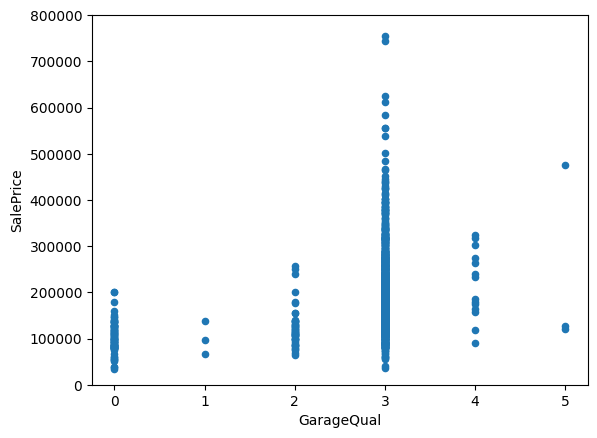

In [147]:
var = 'GarageQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [148]:
df.drop('GarageCond', axis=1, inplace=True)

lets drop all of the Basement variables except Basement Quality, because the parameter already describes everything related to basements

In [149]:
df.drop(['Id','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], axis=1, inplace=True)

In [150]:
df['BsmtQual'] = df['BsmtQual'].map(qual_map)

As we can see, we should keep the Basement Quality parameter, as it has a moderate effect on the price

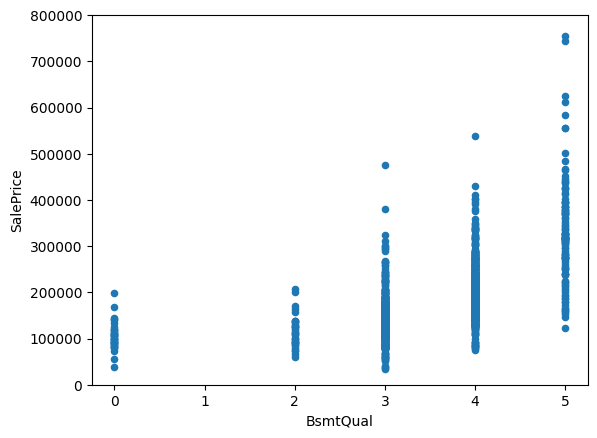

In [151]:
var = 'BsmtQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [152]:
df = pd.get_dummies(df)

_


<Axes: xlabel='GarageQual', ylabel='SalePrice'>

In [153]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,  Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor



In [154]:

X = df.drop(columns='SalePrice')
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
y_train_log = np.log(y_train)


model = LinearRegression()
crossv = 10

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler(),
    None
]
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())  # Key step name
])

# Parameter grid matches 'regressor'
param_grid = [
    {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False],
        'regressor__positive': [True, False]
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        'regressor': [Ridge(max_iter=10000, random_state=42)],
        'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
        'regressor__fit_intercept': [True, False]
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
        'regressor': [Lasso(max_iter=10000, random_state=42)],
        'regressor__alpha': [100.0, 1000.0],
        'regressor__fit_intercept': [True, False]
    },
    {
        'scaler': [None],
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100],
        'regressor__max_depth': [10],
        'regressor__min_samples_split': [5],
        'regressor__min_samples_leaf': [2]
    }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True
)


In [155]:
dagshub.init(repo_owner='CarlTeapot', repo_name='ML_assignment1', mlflow=True)


name = "Linear Regression with regular cross validation training on SalePrice values"


with mlflow.start_run(run_name = name):

        #grid_search.fit(X_train, y_train_log)
        grid_search.fit(X_train, y_train)
        y_test_pred = grid_search.best_estimator_.predict(X_test)
        y_train_pred = grid_search.best_estimator_.predict(X_train)
        y_test_pred_exp = np.exp(y_test_pred)
        y_train_pred_exp = np.exp(y_train_pred)

       # test_rmse =  np.sqrt(mean_squared_error(y_test, y_test_pred_exp))
        #train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_exp))
        test_rmse =  np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        log_test_rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_test_pred)))
        mlflow.log_params(grid_search.best_params_)
        mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model") 
        mlflow.log_metric("Train set Root Mean Square Error ", train_rmse)
        mlflow.log_metric("Test set Root Mean Square Error ", test_rmse)
        mlflow.log_metric("Log of Test set Root Mean Square Error ", log_test_rmse)
        print("Best Score:", grid_search.best_score_)
        print("Test RMSE:", test_rmse)



Initialized MLflow to track repo "CarlTeapot/ML_assignment1"

Repository CarlTeapot/ML_assignment1 initialized!

Fitting 10 folds for each of 73 candidates, totalling 730 fits
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, scaler=StandardScaler(); total time=   0.1s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, scaler=StandardScaler(); total time=   0.1s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, scaler=StandardScaler(); total time=   0.1s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, scaler=StandardScaler(); total time=   0.1s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, scaler=StandardScaler(); total time=   0.1s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, scaler=StandardScaler(); total time=   0.1s
[CV] END regressor=LinearRegression(), regressor__fit_intercept=True, regressor__positive=True, s

/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.513e+10, tolerance: 4.155e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=RobustScaler(); total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+11, tolerance: 4.158e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=RobustScaler(); total time=   0.7s
[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=RobustScaler(); total time=   0.4s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.449e+11, tolerance: 4.112e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.217e+11, tolerance: 4.048e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.141e+11, tolerance: 4.050e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.353e+11, tolerance: 4.180e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.349e+11, tolerance: 4.124e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.125e+11, tolerance: 4.133e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.284e+11, tolerance: 4.178e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+11, tolerance: 4.155e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.369e+11, tolerance: 4.158e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.302e+11, tolerance: 4.099e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=100.0, regressor__fit_intercept=False, scaler=None; total time=   0.7s
[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=True, scaler=StandardScaler(); total time=   0.0s
[CV] END regressor=Lasso(max_iter=10000, random_state=42),

/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.270e+11, tolerance: 4.112e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.967e+11, tolerance: 4.048e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.696e+11, tolerance: 4.050e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.329e+11, tolerance: 4.180e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.226e+11, tolerance: 4.124e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.021e+11, tolerance: 4.133e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.970e+11, tolerance: 4.178e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.941e+11, tolerance: 4.155e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e+11, tolerance: 4.158e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s


/home/mate/repos/ML_assignment1/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.092e+11, tolerance: 4.099e+09
  model = cd_fast.enet_coordinate_descent(


[CV] END regressor=Lasso(max_iter=10000, random_state=42), regressor__alpha=1000.0, regressor__fit_intercept=False, scaler=None; total time=   0.6s
[CV] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=100, scaler=None; total time=   0.9s
[CV] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=100, scaler=None; total time=   0.9s
[CV] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=100, scaler=None; total time=   0.9s
[CV] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=10, regressor__min_samples_leaf=2, regressor__min_samples_split=5, regressor__n_estimators=100, scaler=None; total time=   0.9s
[CV] END regressor=R

/tmp/ipykernel_34230/2932841027.py:13: RuntimeWarning: overflow encountered in exp
  y_test_pred_exp = np.exp(y_test_pred)
/tmp/ipykernel_34230/2932841027.py:14: RuntimeWarning: overflow encountered in exp
  y_train_pred_exp = np.exp(y_train_pred)
2025/04/09 20:22:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Score: -32094.225922530848
Test RMSE: 24163.8797810723
🏃 View run Linear Regression with regular cross validation training on SalePrice values at: https://dagshub.com/CarlTeapot/ML_assignment1.mlflow/#/experiments/0/runs/d4d9bd07e16e4bf3ad16699056ed0cc8
🧪 View experiment at: https://dagshub.com/CarlTeapot/ML_assignment1.mlflow/#/experiments/0
